In [1]:
# Install required packages in the current Jupyter kernel
# Uncomment the following lines if you need to install these libraries
# If you run into permission issues, try with the --user option
#import sys
#!pip install -q rdflib networkx matplotlib
#!{sys.executable} -m pip install rdflib networkx matplotlib pandas stringdb --user


In [17]:
%load_ext autoreload
%autoreload 2
import sampler
import grabhogs_sparql
import map2string_fast
import addfrombloom
import rdflib
import SPARQLWrapper
import colour
import itertools
import networkx as nx
import glob
from matplotlib import pyplot as plt

In [12]:
datapath = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.links.rdf.v11.5/402676.protein.links.rdf.v11.5.txt.gz'
# RDF graph loading
rg = sampler.load_graph(datapath)

datapath2 = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.info.rdf.v11.5/402676.protein.info.rdf.v11.5.txt.gz'
# RDF graph loading
rg_info  = sampler.load_graph(datapath2)

rdflib Graph loaded successfully with 2620310 triples
rdflib Graph loaded successfully with 14559 triples


In [13]:
links = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/STRING/rdf/protein.links.rdf.v11.5/*.protein.links.rdf.v11.5.txt.gz'
linkfiles = glob.glob(links)
linkfiles = { l:{ 'links':l , 'info':l.replace('protein.links' , 'protein.info' ) } for l in linkfiles}
print(len(linkfiles ))

1831


In [14]:
subjs = rg.subjects( unique = True)
seed = next(subjs)
print(seed)

https://string-db.org/network/402676.B6JXZ5


In [15]:
subg = sampler.sample( rg = rg , seed = seed,  layer_limit= 2 , sample_run = 20 )
print(set([p for p in subg.predicates()]))
print("rdflib Graph sampled successfully with {} triples".format(len(subg)))



176 690
{rdflib.term.URIRef('https://string-db.org/rdf/any-confidence'), rdflib.term.URIRef('https://string-db.org/rdf/highest-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff')}
rdflib Graph sampled successfully with 528 triples


In [16]:
subg = sampler.add_xrefs( rg_info , subg )
print("rdflib Graph annotated successfully with {} triples".format(len(subg)))
print(set([p for p in subg.predicates()]))
cross_ref = rdflib.term.URIRef("http://purl.org/lscr#xrefUniprot")
i = 0 
for s,p,o in subg.triples((None, cross_ref, None)):
    print(s,p,o)
    i+= 1
    if i > 10:
        break

80
80
rdflib Graph annotated successfully with 608 triples
{rdflib.term.URIRef('https://string-db.org/rdf/highest-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/medium-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/high-confidence-cutoff'), rdflib.term.URIRef('https://string-db.org/rdf/any-confidence'), rdflib.term.URIRef('http://purl.org/lscr#xrefUniprot')}
https://string-db.org/network/402676.B6K0A5 http://purl.org/lscr#xrefUniprot http://purl.uniprot.org/uniprot/B6K0A5
https://string-db.org/network/402676.B6JY01 http://purl.org/lscr#xrefUniprot http://purl.uniprot.org/uniprot/B6JY01
https://string-db.org/network/402676.B6JW66 http://purl.org/lscr#xrefUniprot http://purl.uniprot.org/uniprot/B6JW66
https://string-db.org/network/402676.B6K160 http://purl.org/lscr#xrefUniprot http://purl.uniprot.org/uniprot/B6K160
https://string-db.org/network/402676.B6K2E1 http://purl.org/lscr#xrefUniprot http://purl.uniprot.org/uniprot/B6K2E1
https://string-db.o

In [17]:
#proteins_by_species , results_subj_para , results_subj_ortho  = grabhogs_sparql.grab_hogs( subg , cross_ref = rdflib.term.URIRef("http://purl.org/lscr#xrefUniprot") )

In [18]:
#print(results_subj_ortho)

In [19]:
orthograph =  grabhogs_sparql.grab_hogs_graph( subg , cross_ref , sparql_endpoint= None
            , USE_CASE = 1 , verbose = True , cross_ref_prop = rdflib.term.URIRef("http://purl.org/lscr#xrefUniprot"))

80
Total time for 160 SPARQL queries: 59.66235828399658 seconds (multiple batch calls in: 0 cases)
Num errors: 0


In [20]:
from rdflib import Graph, URIRef
print("rdflib Graph annotated successfully with {} triples".format(len(orthograph)))
#get all species
taxa = [ 'protein1_uniprot_taxon_orth' , 'protein1_uniprot_taxon_para']
species = set( [ o for t in taxa  for s,p,o in orthograph.triples((None, URIRef(t), None))  ])


rdflib Graph annotated successfully with 1064315 triples


In [21]:
#get all the results for that species
taxa = [ 'orth_protein_uniprot_taxon_orth' , 'para_protein_uniprot_taxon_para']
#get all proteins for each species
prots_by_species = { spec: set([s  for s,p,o in orthograph.triples((None, URIRef(t), spec ))]) for t in taxa for spec in species  }
prots_by_species = { spec:prots_by_species[spec] for spec in prots_by_species if len(prots_by_species[spec])   }
prots_by_species = { spec:[ p.replace('http://purl.uniprot.org/uniprot/' , '' ) for p in prots_by_species[spec] ] for spec in prots_by_species }


In [22]:
server = 'dna066'
ortho_xrefgraph = map2string_fast.mapall(prots_by_species , serverurl= "http://"+server+":3030/string_fuseki/sparql" , retgraph = True)
print(len(ortho_xrefgraph))

NameError: name 'traceback' is not defined

In [ ]:
orthograph += ortho_xrefgraph
subg += orthograph
#we have interactions for one species and ortho info to all others

In [ ]:
filters = addfrombloom.load_filters()

In [ ]:
import addfrombloom
pred = rdflib.term.URIRef('http://purl.org/lscr#xrefUniprot')
interactions = []
for i,spec in enumerate(prots_by_species):
    stringids = [ s for prot in prots_by_species[spec] for s,p,o in orthograph.triples((None, pred , URIRef('http://purl.uniprot.org/uniprot/'+prot) )) ]
    stringids = [ s.replace('https://string-db.org/network/' , '' ) for s in stringids ]
    before = len(interactions)
    if len(stringids ) > 2 :
        interactions += addfrombloom.check_allvall( objects = stringids , urlstring = 'https://string-db.org/network/' , filters = filters )
        if len(interactions)-before>0:
            print('found {} interactions for species {}'.format(len(interactions)-before , spec))
            print(len(subg))
            for inter in interactions:
                subg = subg.add( inter)
            print(len(subg))
            interactions = []
    if i % 10 == 0 :
        print('saving')
        v = subg.serialize(format="ttl")
        with open('testgraph_'+str(i)+'.ttl', 'w') as graphout:
            graphout.write(v)

In [ ]:
#halelujah we have a graph with everything in it
#serialize to turtle format
v = subg.serialize(format="ttl")
with open('testgraph.ttl', 'w') as graphout:
    graphout.write(v)

In [18]:
#get a model
import NX2pyg
import buildmodel
import rdflib
import glob
graphs = glob.glob('./test/*.ttl')
import NX2pyg
print(graphs ) 
#load 1 sample to initialize a model
readg.parse('./test/tax_402676.B6JZZ0_seed_402676.ttl')
print(len(readg))
#set prediction link type

pred_s,pred_p,pred_o = ('ns6', '<https://string-db.org/rdf/high-confidence-cutoff>', 'ns6')
#load one heterodata sample
data , inputdims , interactions  = NX2pyg.rdf2hetero(readg)
print(data , inputdims , interactions )
#set final layer before linkpred size
outputdims = { t : 50 for t in inputdims }

['./test/tax_9606.ENSP00000357838_seed_9606.ttl', './test/tax_402676.B6JZZ0_seed_402676.ttl', './test/tax_59689.fgenesh2_kg.5__2757__AT3G62670.1_seed_59689.ttl', './test/tax_59689.fgenesh2_kg.3__1006__AT3G09820.1_seed_59689.ttl', './test/tax_59689.fgenesh2_kg.4__2551__AT2G43760.3_seed_59689.ttl', './test/tax_402676.B6K648_seed_402676.ttl', './test/tax_9606.ENSP00000329295_seed_9606.ttl', './test/tax_59689.fgenesh2_kg.1__1697__AT1G15420.1_seed_59689.ttl', './test/tax_59689.scaffold_600900.1_seed_59689.ttl', './test/tax_402676.B6JVE4_seed_402676.ttl', './test/tax_9606.ENSP00000480012_seed_9606.ttl', './test/tax_59689.fgenesh1_pm.C_scaffold_1000066_seed_59689.ttl', './test/tax_59689.scaffold_802252.1_seed_59689.ttl', './test/tax_59689.Al_scaffold_0004_854_seed_59689.ttl', './test/tax_9606.ENSP00000448073_seed_9606.ttl', './test/tax_402676.B6JVZ4_seed_402676.ttl', './test/tax_9606.ENSP00000368190_seed_9606.ttl', './test/tax_59689.fgenesh2_kg.4__3062__AT2G48100.3_seed_59689.ttl', './test/ta

In [23]:
#init model
model = buildmodel.HeteroGCN_linkpred( linkpred = (pred_s,pred_p,pred_o) , inpudims= inputdims, interactions = interactions , outputdims= outputdims , dropout = .3 , layers = [500,500,500 , 500] , tan_final = True)
print(model)

{('ns3', '<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_para_protein>', 'ns3'): EdgeConv(), ('ns3', 'rev_<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_para_protein>', 'ns3'): EdgeConv(), ('ns3', '<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_orth_protein>', 'ns3'): EdgeConv(), ('ns3', 'rev_<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_orth_protein>', 'ns3'): EdgeConv(), ('ns3', '<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_taxon_orth>', 'ns4'): EdgeConv(), ('ns4', 'rev_<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_taxon_orth>', 'ns3'): EdgeConv(), ('ns3', '<file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_taxon>', 'ns4'): EdgeConv(), ('ns4', 're

In [ ]:
#train
import torch
import tqdm
import torch_geometric.transforms as T
import torch.nn.functional as F
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
for subgraph in graphs[0:5]:
    print('learning from ' , subgraph)
    readg = rdflib.Graph()
    readg.parse(subgraph)
    data , inputdims , interactions  = NX2pyg.rdf2hetero(readg)
    if pred_s == pred_o:
        revpred = (pred_s,pred_p,pred_o)
    else:
        revpred  = pred_o, 'rev_'+pred_p,pred_s
    transform = T.RandomLinkSplit(
        num_val=0.1,  # percentage of VALIDATION
        num_test=0.1,  # percentage of TESTING
        disjoint_train_ratio=0.3,  # this somehow has to do with the 30% we need for supervision
        neg_sampling_ratio=2,  # TODO
        add_negative_train_samples=True,  # TODO
        edge_types=(pred_s,pred_p,pred_o),
        rev_edge_types=(pred_s,pred_p,pred_o), 
    )
    train_data, val_data, test_data = transform(data)
    # Define seed edges:
    ## HERE IS where you would basically train with both types of links, but then for testing you would only want to generate INTERACT
    edge_label_index = train_data[pred_s,pred_p,pred_o].edge_label_index
    edge_label = train_data[pred_s,pred_p,pred_o].edge_label
    train_loader = LinkNeighborLoader(
        data=train_data,  # TODO
        num_neighbors=[20, 20 , 20],  # TODO
        edge_label_index=((pred_s,pred_p,pred_o), edge_label_index),
        #edge_label=edge_label,
        neg_sampling_ratio=2,  # TODO
        batch_size=1000,
        shuffle=True
    )
    for epoch in range(1, 10):
        total_loss = total_examples = 0
        for sampled_data in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            sampled_data = sampled_data.to(device)
            pred = model.forward(sampled_data )
            loss = F.binary_cross_entropy_with_logits(pred , sampled_data[pred_s,pred_p,pred_o].edge_label)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * pred.numel() # numel = number of elements
            total_examples += pred.numel()
        print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

        
        
        

Device: 'cuda'
learning from  ./test/tax_9606.ENSP00000357838_seed_9606.ttl
ns3 50033 ns3 50033
nadj: 16505.0
ns3 50033 ns3 50033
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_para_protein 16505
nadj: 47999.0
ns3 50033 ns3 50033
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_orth_protein 47999
ns3 50033 ns4 2422
nadj: 36553.0
ns3 50033 ns4 2422
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_taxon_orth 36553
nadj: 54.0
ns3 50033 ns4 2422
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/protein1_taxon 54
nadj: 13787.0
ns3 50033 ns4 2422
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/para_protein_taxon_para 13787
nadj: 39479.0
ns3 50033 ns4 2422
file:///work/FAC/FBM/DBC/cdessim2/default/dmoi/projects/RDF_Graphnet/rdf2network/test/orth_protein_taxon_orth 39479
nadj: 7046.0

  0%|          | 0/7 [00:00<?, ?it/s]/work/FAC/FBM/DBC/cdessim2/default/dmoi/miniconda3/envs/ML2/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 001, Loss: 3.3026


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 002, Loss: 1.2768


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 003, Loss: 0.9960


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 004, Loss: 0.9365


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 005, Loss: 0.8690


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 006, Loss: 0.8348


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 007, Loss: 0.7972


100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


Epoch: 008, Loss: 0.7690


100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


Epoch: 009, Loss: 0.7549
learning from  ./test/tax_402676.B6JZZ0_seed_402676.ttl


In [ ]:
#pred  and validate for one validation set
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt


val_loader = LinkNeighborLoader(
    data=val_data,  # TODO
    num_neighbors=[20, 20 , 20],  # TODO
    edge_label_index=((pred_s,pred_p,pred_o), edge_label_index),
    #edge_label=edge_label,
    neg_sampling_ratio=2,  # TODO
    batch_size=1000,
    shuffle=True
)

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        # TODO: Collect predictions and ground-truths and write them into
        # `preds` and `ground_truths`.
        sampled_data = sampled_data.to(device)
        pred = model.forward(sampled_data)
        preds += [pred]
        ground_truths += [sampled_data[pred_s,pred_p,pred_o].edge_label]

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)

print()
print(f"Validation AUC: {auc:.4f}")

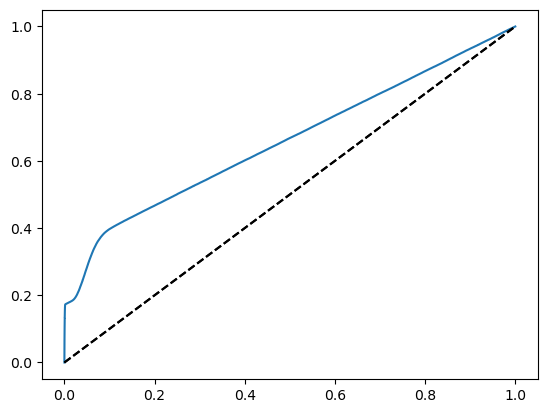

In [47]:

from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(ground_truth, pred)
plt.plot(fpr,tpr)
plt.plot([[0,0],[1,1]] , c = 'black' , linestyle='dashed')
plt.show()

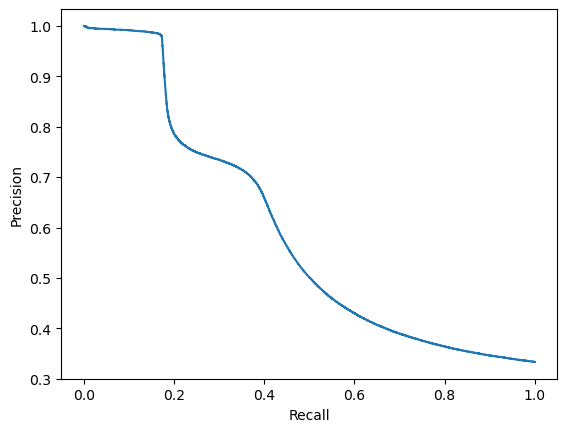

In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(ground_truth, pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()